В приложении по доставке готовых блюд были проведены два теста:

- В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные 
- Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый

Необходимо определить, есть ли между группами различия и сделать выводы. 

Описание данных:

5_task_1:

- id – id клиента в эксперименте
- group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)
- events – сколько блюд суммарно было заказано за период

5_task_2:

- id – id клиента в эксперименте
- segment – сегмент (high/low)
- group – вид кнопки (control – старая версия, test – новая версия)
- events – сколько блюд суммарно было заказано за период

In [21]:
import pingouin as pg
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [29]:
task_1 = pd.read_csv('5_task_1.csv')
task_2 = pd.read_csv('5_task_2.csv')

In [3]:
task_1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [4]:
task_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      30000 non-null  int64 
 1   group   30000 non-null  object
 2   events  30000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 703.2+ KB


In [4]:
task_2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [6]:
task_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  int64  
 1   group    100000 non-null  object 
 2   segment  100000 non-null  object 
 3   events   100000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.1+ MB


## В первом эксперементе необходимо проверить, какой формат фотографий блюд является наилучшим.

Лучшим будем считать тот формат, при котором среднее число заказов наибольшее. 

- Проверим, являются ли дисперсии внутри групп гомогенными 

In [9]:
group_A = task_1.query('group == "A"').events.to_list()
group_B = task_1.query('group == "B"').events.to_list()
group_C = task_1.query('group == "C"').events.to_list()

In [7]:
group_A

0       14
1       41
2       30
3       37
4       38
        ..
9995    25
9996    25
9997    30
9998    21
9999    21
Name: events, Length: 10000, dtype: int64

In [8]:
stats, p_value = scipy.stats.levene(group_A, group_B, group_C)

alpha = 0.05

if p_value > alpha :
    print (f"Принимаем нулевую гипотезу об гомогенности дисперсии, p = {p_value}")
else :
    print ( f"Отвергаем нулевую гипотезу об гетерогенности дисперсии, p = {p_value}")

Принимаем нулевую гипотезу об гомогенности дисперсии, p = 0.1041327199523974


In [14]:
# через библиотеку pingouin
pg.homoscedasticity(data = task_1, dv="events", group="group")

,W,pval,equal_var
levene,2.26226,0.104133,True


- Протестируем данные на нормальность

In [16]:
print(scipy.stats.normaltest(group_A))
print(scipy.stats.normaltest(group_B))
print(scipy.stats.normaltest(group_C))

NormaltestResult(statistic=2.1034599402238734, pvalue=0.3493328906085719)
NormaltestResult(statistic=0.8410715800223014, pvalue=0.6566948749848232)
NormaltestResult(statistic=3.243725809054571, pvalue=0.19753037588314626)


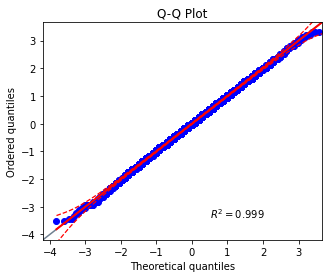

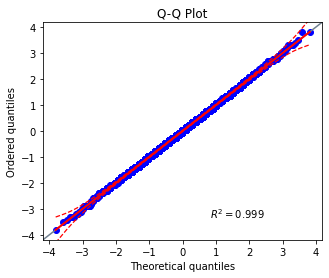

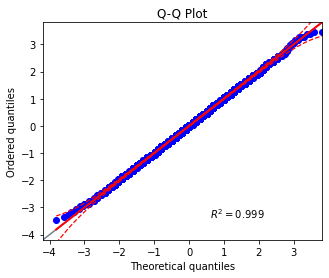

In [19]:
# qq-plots
pg.qqplot(group_A)
pg.qqplot(group_B)
pg.qqplot(group_C)

`Данные во всех трёх группах распределены нормально`

- Сравним средние в группах с помощью однофакторного дисперсионного анализа

In [23]:
scipy.stats.f_oneway(group_A, group_B, group_C)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

In [10]:
pg.anova(data=task_1, dv='events', between='group' )

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


`Группы значимо различаются между собой`

- Теперь используем критерий Тьюки и определим, между какими грууппами есть статистиски значимые отличия.

In [12]:
MultiComp = MultiComparison(task_1.events, task_1.group)

print(MultiComp.tukeyhsd().summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
     A      B    8.034 0.001   7.7038  8.3642   True
     A      C  -2.1093 0.001  -2.4395 -1.7791   True
     B      C -10.1433 0.001 -10.4735 -9.8131   True
----------------------------------------------------


In [14]:
pg.pairwise_tukey(data=task_1, dv='events', between='group')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.001,-0.806377
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.001,0.211712
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.001,1.018089


`Между всеми группами есть статистически значимые различия`

**Вывод** : будем использовать квадратные картинки (группа В), поскольку число покупок в этой группе статистически значимо выше, чем если мы используем прямоугольные картинки.

## Перейдём ко второму эксперементу.

### Требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента. 

- Визуализируем распределение events для контрольной и тестовой группы. 

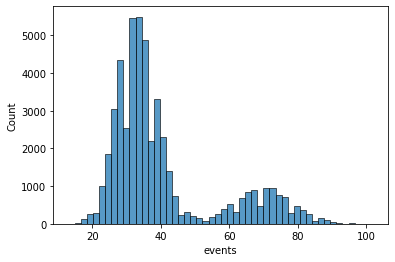

In [34]:
sns.histplot(data = task_2.query('group == "test"'),x = 'events', bins=50)

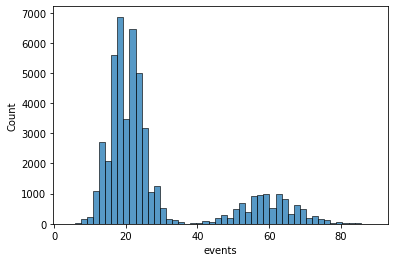

In [33]:
sns.histplot(data = task_2.query('group == "control"'),x = 'events', bins=50)

- Посчитаем среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя. 

In [30]:
task_2.groupby(['group','segment']).events.describe().round(2)

count   mean   std   min   25%   50%   75%    max
group   segment                                                     
control high     10000.0  59.97  7.81  31.0  55.0  60.0  65.0   89.0
        low      40000.0  20.03  4.47   4.0  17.0  20.0  23.0   41.0
test    high     10000.0  69.94  8.40  40.0  64.0  70.0  76.0  102.0
        low      40000.0  33.03  5.72  13.0  29.0  33.0  37.0   59.0

In [31]:
formula = 'events ~ segment + group + segment:group'
model = ols(formula, task_2).fit()
aov_table = anova_lm(model)

In [32]:
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
segment,1.0,2.362480e+07,2.362480e+07,689756.377484,0.000000e+00
group,1.0,3.837195e+06,3.837195e+06,112031.864119,0.000000e+00
segment:group,1.0,3.664244e+04,3.664244e+04,1069.823273,2.060261e-233
Residual,99996.0,3.424956e+06,3.425093e+01,NaN,NaN


In [33]:
# ещё один вариант 
pg.anova(data=task_2, dv="events", between=["group", "segment"])

,Source,SS,DF,MS,F,p-unc,np2
0,group,3.837195e+06,1.0,3.837195e+06,112031.864119,0.000000e+00,0.528383
1,segment,2.362480e+07,1.0,2.362480e+07,689756.377484,0.000000e+00,0.873383
2,group * segment,3.664244e+04,1.0,3.664244e+04,1069.823273,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


- Визуализируем результаты теста

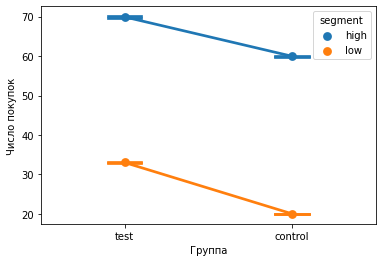

In [36]:
sns.pointplot(x = 'group', y = 'events', hue = 'segment', data = task_2, capsize = .2)
plt.xlabel('Группа')
plt.ylabel('Число покупок')
plt.show()

` Оба фактора оказывают статистически значимое влияние на зависимую переменную, а среднее значение числа покупок увеличилось`

Для последующих сравнений между группами соединим колонки group и segment в combination, чтобы потом передать в аргумент groups в MultiComparison.

In [34]:
task_2['combination'] = task_2['group'] + '\\' + task_2['segment']
task_2.head()

,id,group,segment,events,combination
0,83440,test,high,78.0,test\high
1,96723,test,high,71.0,test\high
2,68719,test,high,80.0,test\high
3,50399,test,high,80.0,test\high
4,95613,test,high,78.0,test\high


- Определим, между каким именно группами статистически значимые различия

In [35]:
MultiComp = MultiComparison(task_2.events, groups = task_2.combination)

print(MultiComp.tukeyhsd().summary())

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2   meandiff p-adj  lower    upper   reject
----------------------------------------------------------------
control\high control\low -39.9392 0.001 -40.1073 -39.7711   True
control\high   test\high   9.9677 0.001   9.7551  10.1803   True
control\high    test\low -26.9449 0.001  -27.113 -26.7768   True
 control\low   test\high  49.9069 0.001  49.7388   50.075   True
 control\low    test\low  12.9944 0.001   12.888  13.1007   True
   test\high    test\low -36.9126 0.001 -37.0807 -36.7445   True
----------------------------------------------------------------


**Вывод** : фактор group оказался ЗНАЧИМЫМ, фактор segment – ЗНАЧИМЫМ, их взаимодействие – ЗНАЧИМО. Судя по графику, для всех групп среднее значение events УВЕЛИЧИЛОСЬ, поэтому решение: ВЫКАТЫВАЕМ НОВУЮ ВЕРСИЮ.